<a href="https://colab.research.google.com/github/ellerywuyn/LEAR-lab/blob/3-stratification-and-percent-offensive/profanity_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install profanity-filter
from profanity_filter import ProfanityFilter
!python -m spacy download en
pf = ProfanityFilter()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 KB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 KB 6.1 MB/s eta 0:00:00
  Created wheel for ordered-set: filename=ordered_set-3.1.1-py2.py3-none-any.whl size=7821 sha256=0e2c6358a5da054839f992085a28e24d065571cae8754e01ed3747561709db24
  Stored in directory: /root/.cache/pip/wheels/0c/c1/59/fab3ebd141bf02663ee9773f16b18118ef7d51db

In [41]:
import re
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import random
import plotly.graph_objs as go

In [3]:
tweets_df = pd.read_csv("/content/drive/MyDrive/labeled_data.csv")
tweets_df_interest = tweets_df[["class", "tweet"]]
tweets_df_interest = tweets_df_interest[tweets_df_interest["class"].isin([1,2])]
n_sample = sum(tweets_df_interest["class"] == 2)
class1 = tweets_df_interest["class"][tweets_df_interest["class"] == 1].sample(n_sample, random_state = 1).index
class2 = tweets_df_interest["class"][tweets_df_interest["class"] == 2].index
sampled_tweets_df = tweets_df_interest.loc[class1.union(class2)]
sampled_tweets_df["class"] = sampled_tweets_df["class"].replace(2, 0)

In [4]:
# use the model to get predictions and store them in a new column named "predictions" in sampled_tweets_df
sampled_tweets_df['num_bad_words'] = sampled_tweets_df.apply(lambda x: len(re.findall('\*{2,}', pf.censor(x["tweet"]))), axis=1)

In [5]:
sampled_tweets_df['num_total_words'] = sampled_tweets_df.apply(lambda x: len(x["tweet"].split()), axis=1)

In [6]:
sampled_tweets_df['prop_bad_words'] = sampled_tweets_df['num_bad_words'] / sampled_tweets_df['num_total_words']

In [7]:
# define a function to generate labels using the transformer model
def get_label_n(input):
  return 1 if pf.is_profane(input) else 0

In [8]:
# use the model to get predictions and store them in a new column named "predictions" in sampled_tweets_df
sampled_tweets_df['prediction'] = sampled_tweets_df.apply(lambda x: get_label_n(x["tweet"]), axis=1)

# change the "class" column to "label" for clarity purposes
sampled_tweets_df = sampled_tweets_df.rename(columns = {"class": "label"})

# reorder the columns
sampled_tweets_df = sampled_tweets_df.loc[:,['tweet', 'label', 'prediction', 'num_bad_words', 'num_total_words', 'prop_bad_words']]

In [9]:
sampled_tweets_df

,tweet,label,prediction,num_bad_words,num_total_words,prop_bad_words
0,!!! RT @mayasolovely: As a woman you shouldn't...,0,0,0,25,0.000000
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",1,1,2,19,0.105263
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",1,1,2,20,0.100000
7,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,1,1,1,13,0.076923
23,""" fuck no that bitch dont even suck dick "" &#1...",1,1,4,19,0.210526
...,...,...,...,...,...,...
24772,you might as well gone pussy pop on a stage,1,1,1,10,0.100000
24773,you niggers cheat on ya gf's? smh....,1,1,1,7,0.142857
24774,you really care bout dis bitch. my dick all in...,1,1,2,12,0.166667
24779,"you've gone and broke the wrong heart baby, an...",0,0,0,13,0.000000


In [10]:
num_bad_words_counts = sampled_tweets_df['num_bad_words'].value_counts()
num_bad_words_counts

0    4832
1    2291
2     868
3     247
4      60
5      19
6       7
7       2
Name: num_bad_words, dtype: int64

<Axes: ylabel='Frequency'>

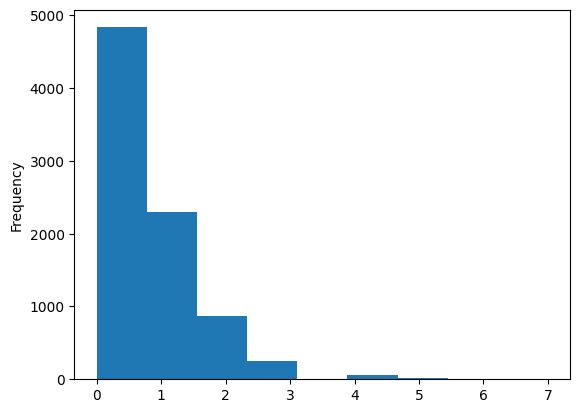

In [11]:
sampled_tweets_df['num_bad_words'].plot(kind='hist', bins=9)

<Axes: ylabel='Frequency'>

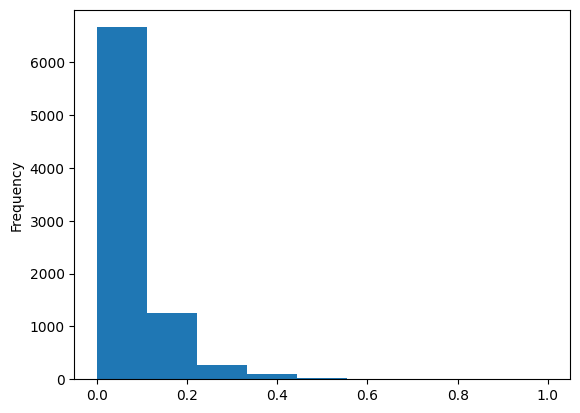

In [12]:
sampled_tweets_df['prop_bad_words'].plot(kind='hist', bins=9)

In [13]:
df_0_bad = sampled_tweets_df[sampled_tweets_df['num_bad_words'] == 0]
df_1_bad = sampled_tweets_df[sampled_tweets_df['num_bad_words'] == 1]
df_2_bad = sampled_tweets_df[sampled_tweets_df['num_bad_words'] == 2]
df_3_bad = sampled_tweets_df[sampled_tweets_df['num_bad_words'] == 3]
df_4_plus_bad = sampled_tweets_df[sampled_tweets_df['num_bad_words'] >= 4]

In [14]:
df_4_plus_bad

,tweet,label,prediction,num_bad_words,num_total_words,prop_bad_words
23,""" fuck no that bitch dont even suck dick "" &#1...",1,1,4,19,0.210526
135,"""@Gotti_LTF: Happy Bday Bitch Ass Nigga @JetsA...",1,1,4,11,0.363636
153,"""@JoeBudden: stop being scared to choke her du...",1,1,4,26,0.153846
339,"""@iDntWearCondoms: Watch women try to argue wi...",1,1,4,25,0.160000
686,#ChristianBale should be KISSING #Moses ass fo...,1,1,5,22,0.227273
...,...,...,...,...,...,...
21910,Thirsty fo da bitches saggin my pants n shit ....,1,1,4,23,0.173913
22045,This girl is the nastiest skank bitch I've eve...,1,1,4,20,0.200000
23349,You know i stay on fuck a bitch shit but with ...,1,1,4,20,0.200000
23369,You like where the hell is yo bitch meanwhile ...,1,1,4,19,0.210526


In [15]:
df_dict = {
    "0 bad words" : df_0_bad,
    "1 bad word" : df_1_bad,
    "2 bad words" : df_2_bad,
    "3 bad words" : df_3_bad,
    "4+ bad words" : df_4_plus_bad,
}

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

0 bad words 
                precision    recall  f1-score   support

not offensive       0.82      1.00      0.90      3974
    offensive       0.00      0.00      0.00       858

     accuracy                           0.82      4832
    macro avg       0.41      0.50      0.45      4832
 weighted avg       0.68      0.82      0.74      4832

     Metrics  Values
0   Accuracy    0.82
1  Precision    0.00
2     Recall    0.00
3         F1    0.00 



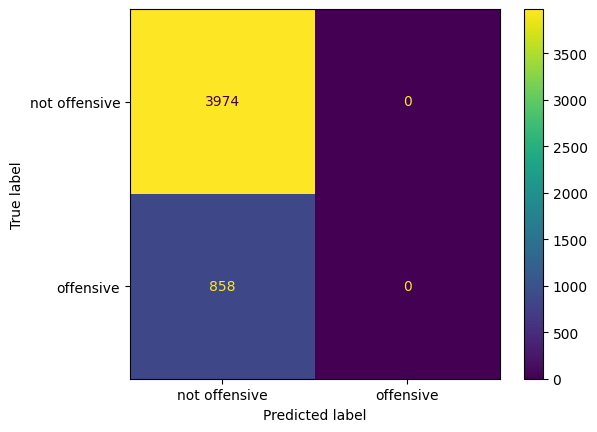

1 bad word 
                precision    recall  f1-score   support

not offensive       0.75      0.02      0.03       175
    offensive       0.92      1.00      0.96      2116

     accuracy                           0.92      2291
    macro avg       0.84      0.51      0.50      2291
 weighted avg       0.91      0.92      0.89      2291

     Metrics  Values
0   Accuracy    0.92
1  Precision    0.92
2     Recall    1.00
3         F1    0.96 



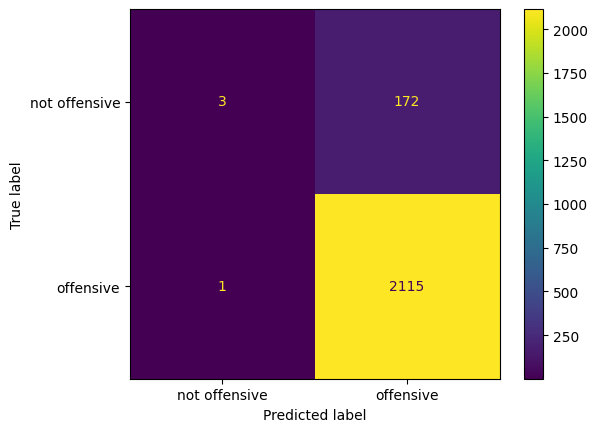

2 bad words 
                precision    recall  f1-score   support

not offensive       0.60      0.23      0.33        13
    offensive       0.99      1.00      0.99       855

     accuracy                           0.99       868
    macro avg       0.79      0.61      0.66       868
 weighted avg       0.98      0.99      0.98       868

     Metrics  Values
0   Accuracy    0.99
1  Precision    0.99
2     Recall    1.00
3         F1    0.99 



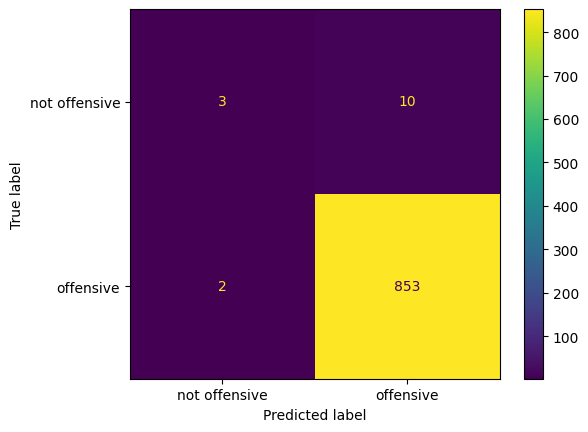

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3 bad words 
                precision    recall  f1-score   support

not offensive       0.00      0.00      0.00         1
    offensive       1.00      1.00      1.00       246

     accuracy                           1.00       247
    macro avg       0.50      0.50      0.50       247
 weighted avg       0.99      1.00      0.99       247

     Metrics  Values
0   Accuracy     1.0
1  Precision     1.0
2     Recall     1.0
3         F1     1.0 



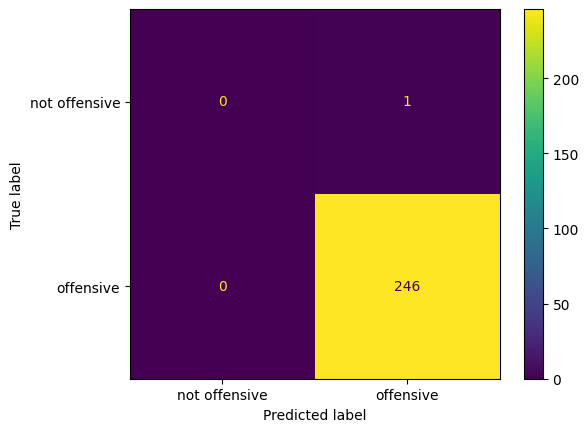

'4+ bad words' only has the offensive class


In [18]:
target_names = ["not offensive", "offensive"]
for key in df_dict:
  # print the classification reports for all 5
  try:
    print(key, "\n", classification_report(df_dict[key]["label"], df_dict[key]["prediction"], target_names=target_names))

    metrics = {
      "Metrics": ["Accuracy", "Precision", "Recall", "F1"],
      "Values": [round(np.average(accuracy_score(df_dict[key]["label"], df_dict[key]["prediction"])), 2), 
                round(np.average(precision_score(df_dict[key]["label"], df_dict[key]["prediction"])), 2), 
                round(np.average(recall_score(df_dict[key]["label"], df_dict[key]["prediction"])), 2), 
                round(np.average(f1_score(df_dict[key]["label"], df_dict[key]["prediction"])), 2)]
    }
    print(pd.DataFrame(metrics), "\n")
    cm = confusion_matrix(df_dict[key]["label"], df_dict[key]["prediction"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot()
    plt.show()
  except ValueError:
    print("'4+ bad words' only has the offensive class")


### Misclassifications

In [17]:
df_0_bad[(df_0_bad["prediction"] == 0) & (df_0_bad["label"] == 1)]

,tweet,label,prediction,num_bad_words,num_total_words,prop_bad_words
39,""" like Snoop said in 94 we dont love these hoes """,1,0,0,12,0.0
104,"""@ComedyTruth: amen miley &#128591; http://t.c...",1,0,0,20,0.0
208,"""@PRETTyBOSs_BRAt: We don't love these hoes &#...",1,0,0,7,0.0
236,"""@Shun_stokes: My cousin said he share hoes wi...",1,0,0,21,0.0
237,"""@SlimGirl_Probz: i'm hungry but ionn wanna sp...",1,0,0,14,0.0
...,...,...,...,...,...,...
24696,why even get pregnant by someone that isn't an...,1,0,0,21,0.0
24739,yeah I'm small den a hoe http://t.co/VV3qdTo7MG,1,0,0,7,0.0
24740,yeah i got soul i was brought up by colored wo...,1,0,0,11,0.0
24754,"you are a hoe, hoe, &amp; a hoe.",1,0,0,8,0.0


### False Negatives

In [21]:
false_neg_list = df_0_bad[(df_0_bad["prediction"] == 0) & (df_0_bad["label"] == 1)]["tweet"].to_list()

In [24]:
false_neg = " ".join(false_neg_list)

In [25]:
false_neg

'" like Snoop said in 94 we dont love these hoes " "@ComedyTruth: amen miley &#128591; http://t.co/P2Kb2tfyxr"okay, but she don\'t need to act like a hoe just bc she\'s "emotionally damaged" foh "@PRETTyBOSs_BRAt: We don\'t love these hoes &#128080;&#128581;" "@Shun_stokes: My cousin said he share hoes with his brothers. He said sharing is caring and he love his brothers &#128514;" "@SlimGirl_Probz: i\'m hungry but ionn wanna spend my money on food&#128530;"Broke hoe problems &#128514;&#128514;&#128514;&#128128; "@YoungRicooo: &#8220;@WexicanAfro702: Don\'t take advantage of a nice person&#8221;@ hoes"@ everyjuan "@whoiscoreyking: Chase money &#128176; not &#128581; hoes &#128111; &#128175;&#128175;"&#58399;&#58399;&#58399;&#58399; "@wodaeeex3: I Want Snake Bites , MY Industrial Piercin &amp; A Tattoo"Dem hoe accessories dea &#128064;&#128064;&#128056;&#9749; "Eff it. Let\'s go after the cripple." http://t.co/kSaMx1JPfV "Her great grandmas a hoe,her grandmas a hoe,her moms and a hoe, a

In [26]:
words = false_neg.lower().split()

In [30]:
# Create a dictionary to store the frequency of each word
word_freq = dict(Counter(words))

In [32]:
sorted_word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))

In [33]:
sorted_word_freq

{'a': 299,
 'hoes': 270,
 'rt': 259,
 'i': 223,
 'hoe': 214,
 'the': 205,
 'you': 200,
 'to': 164,
 'that': 109,
 'my': 101,
 'and': 89,
 'these': 88,
 'like': 87,
 'on': 84,
 'be': 80,
 'of': 77,
 'is': 74,
 'me': 72,
 'in': 70,
 'got': 59,
 "don't": 54,
 'this': 52,
 'all': 52,
 'it': 50,
 'if': 50,
 "ain't": 50,
 'but': 48,
 'just': 48,
 'she': 47,
 'for': 47,
 'no': 47,
 'u': 46,
 'so': 46,
 'with': 43,
 'not': 43,
 'at': 43,
 'up': 41,
 'your': 41,
 'they': 40,
 'lol': 37,
 'niggah': 37,
 'when': 36,
 "i'm": 35,
 'get': 35,
 'out': 35,
 'some': 34,
 'we': 33,
 'have': 33,
 'know': 32,
 'love': 31,
 '&amp;': 30,
 'trash': 30,
 'want': 29,
 'her': 29,
 'do': 28,
 'was': 28,
 'he': 25,
 'what': 25,
 'are': 24,
 'them': 24,
 'or': 24,
 'one': 22,
 'hoe.': 21,
 'about': 20,
 "it's": 19,
 'niccas': 19,
 'need': 18,
 'bout': 18,
 'let': 18,
 'nicca': 17,
 'can': 17,
 'still': 17,
 'will': 17,
 'now': 17,
 "you're": 17,
 'loyal': 17,
 "y'all": 17,
 'make': 17,
 'how': 17,
 'why': 16,
 'th

In [37]:
first_30_items = dict(itertools.islice(sorted_word_freq.items(), 30))

In [38]:
first_30_items

{'a': 299,
 'hoes': 270,
 'rt': 259,
 'i': 223,
 'hoe': 214,
 'the': 205,
 'you': 200,
 'to': 164,
 'that': 109,
 'my': 101,
 'and': 89,
 'these': 88,
 'like': 87,
 'on': 84,
 'be': 80,
 'of': 77,
 'is': 74,
 'me': 72,
 'in': 70,
 'got': 59,
 "don't": 54,
 'this': 52,
 'all': 52,
 'it': 50,
 'if': 50,
 "ain't": 50,
 'but': 48,
 'just': 48,
 'she': 47,
 'for': 47}

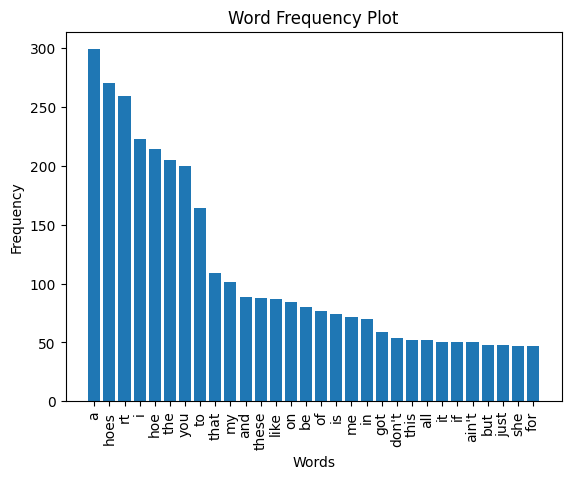

In [40]:
# Plot the word frequency as a bar plot
plt.bar(range(len(first_30_items)), list(first_30_items.values()), align='center')
plt.xticks(range(len(first_30_items)), list(first_30_items.keys()), rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Plot')
plt.show()

In [46]:
sorted_word_freq.values()

dict_values([299, 270, 259, 223, 214, 205, 200, 164, 109, 101, 89, 88, 87, 84, 80, 77, 74, 72, 70, 59, 54, 52, 52, 50, 50, 50, 48, 48, 47, 47, 47, 46, 46, 43, 43, 43, 41, 41, 40, 37, 37, 36, 35, 35, 35, 34, 33, 33, 32, 31, 30, 30, 29, 29, 28, 28, 25, 25, 24, 24, 24, 22, 21, 20, 19, 19, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [52]:
# Create a trace for the bar chart
trace = go.Bar(
    x=list(sorted_word_freq.keys()),
    y=list(sorted_word_freq.values())
)

# Create a layout for the plot
layout = go.Layout(
    title='Bar Chart of Y Values',
    xaxis=dict(title='X Values'),
    yaxis=dict(title='Y Values')
)

# Create a figure object and add the trace and layout
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()

In [55]:
y_values = list(sorted_word_freq.keys())
x_values = list(sorted_word_freq.values())

# Create a trace for the bar chart
trace = go.Bar(
    x=x_values,
    y=y_values,
    orientation='h'
)

# Create a layout for the plot
layout = go.Layout(
    title='Bar Chart of X Values by Y Categories',
    xaxis=dict(title='X Values'),
    yaxis=dict(title='Y Categories')
)

# Create a figure object and add the trace and layout
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()

In [59]:
y_values = list(sorted_word_freq.keys())
x_values = list(sorted_word_freq.values())

fig = go.Figure(go.Bar(
    y = y_values,
    x = x_values,
    orientation = "h",
))

fig.show()

### False Positives

In [ ]:
df_1_bad[(df_1_bad["prediction"] == 1) & (df_1_bad["label"] == 0)]

,tweet,label,prediction,num_bad_words,num_total_words,prop_bad_words
40,""" momma said no pussy cats inside my doghouse """,0,1,1,10,0.100000
186,"""@MaxMayo77: http://t.co/3Jk4kR44X3"" a pissed ...",0,1,1,16,0.062500
188,"""@MaxMayo77: http://t.co/XpSC3makgJ"" sexy lad ...",0,1,1,9,0.111111
241,"""@SportsCenter: USC senior RB Anthony Brown ca...",0,1,1,21,0.047619
243,"""@Stephenwildboy: Chilling &#128069;&#8482; ht...",0,1,1,7,0.142857
...,...,...,...,...,...,...
24051,if u eat fried eggs and leave the yolk entirel...,0,1,1,17,0.058824
24478,stupid teacher talks to @RandyMower like he's ...,0,1,1,8,0.125000
24581,this movie is actually good cuz its so retarded,0,1,1,9,0.111111
24653,wearing pajamas tonight 4 da gook \nUDigg \n\n...,0,1,1,9,0.111111


In [ ]:
df_1_bad[(df_1_bad["prediction"] == 1) & (df_1_bad["label"] == 0)]["tweet"].to_list()

['" momma said no pussy cats inside my doghouse "',
 '"@MaxMayo77: http://t.co/3Jk4kR44X3" a pissed lad past out. I would lick his dirty soles while he slept.',
 '"@MaxMayo77: http://t.co/XpSC3makgJ" sexy lad with hot soles and arches.',
 '"@SportsCenter: USC senior RB Anthony Brown calls head coach Steve Sarkisian a racist and quits team. &#187; http://t.co/JOOsdSubIR" he\'s a bitch',
 '"@Stephenwildboy: Chilling &#128069;&#8482; http://t.co/mik3iPNle6" sexy scally lad',
 '"This recipe calls for a leftover brownie. What the hell is a LEFTOVER brownie? That\'s just a brownie you haven\'t eaten yet."-@EricaNadine26',
 '#BigBird was made by a gay couple. So yes, under a GOP world the bird would not have existed since its creators would be in jail for sodomy.',
 "#Yankees Damn you DirectTv blackout the Yankee game. With a freaking WALK OFF! You're killing me satellite douche.",
 '#Yankees Damn. Well Joe that move to the bullpen really helped.',
 '#porn,#android,#iphone,#ipad,#sex,#xxx, | 

In [ ]:
df_2_bad[(df_2_bad["prediction"] == 1) & (df_2_bad["label"] == 0)]

,tweet,label,prediction,num_bad_words,num_total_words,prop_bad_words
119,"""@EdgarPixar: Overdosing on heavy drugs doesn'...",0,1,2,16,0.125000
397,"""@soxdawg: RAWR!! RT @skinrubberboi: ""My"" sexy...",0,1,2,17,0.117647
1352,&#8220;@KarynHalpin: Where do all the foreskin...,0,1,2,24,0.083333
5248,@ZP3_ the little girl Tom Sawyer gets trapped ...,0,1,2,26,0.076923
6599,@louisck a video i made -- Porn Actress Sexy C...,0,1,2,19,0.105263
13809,Perhaps Ezra Miller is the first crack toward ...,0,1,2,19,0.105263
19300,RT @iv9801: Charlie Sheen engaged to porn star...,0,1,2,19,0.105263
20224,RT @trayn1gga: Alabama is overrated this yr th...,0,1,2,24,0.083333
20476,"Re: Alexander Skarsgard, my roommate has decla...",0,1,2,22,0.090909
23340,"You know I'm not big on the NFL, but I'm so si...",0,1,2,29,0.068966


In [ ]:
df_2_bad[(df_2_bad["prediction"] == 1) & (df_2_bad["label"] == 0)]["tweet"].to_list()

['"@EdgarPixar: Overdosing on heavy drugs doesn\'t sound bad tonight." I do that pussy shit every day.',
 '"@soxdawg: RAWR!! RT @skinrubberboi: "My" sexy French scally. I love him! #frenchscally http://t.co/5idQ3R5Akz" sexy scally woof woof',
 '&#8220;@KarynHalpin: Where do all the foreskins go when they circumcise a guy?&#8221; the Foreskin Fairy takes them after you put them under your pillow',
 '@ZP3_ the little girl Tom Sawyer gets trapped in the cave along with Injun Joe and almost die. injun Joe dies and they find his treasure',
 '@louisck a video i made -- Porn Actress Sexy Capri Anderson Kissing Video with Charlie Sheen http://t.co/VTH4r762 via @youtube',
 'Perhaps Ezra Miller is the first crack toward changing that, regardless of whether he identifies as queer over gay.',
 'RT @iv9801: Charlie Sheen engaged to porn star http://t.co/THMYpFexic\nMens #Health Tips Sex Toy http://t.co/Hxmlrj1w6m The Adult Toys #KISS&#8230;',
 'RT @trayn1gga: Alabama is overrated this yr the last 2

In [ ]:
df_3_bad[(df_3_bad["prediction"] == 1) & (df_3_bad["label"] == 0)]["tweet"].iloc[0]

"He's a pretty damn good actor. But as a gay man it's awesome to see an openly queer actor given the lead role for a major superhero film."

In [ ]:
df_1_bad[df_1_bad["prediction"] == 0]["tweet"]

321      "@complex_uk: Ashley Young has tried to deny t...
9620     Haha a private industry birthday is needed to ...
12297    Laat Zihni Ozdil met rust jullie gemene trolle...
19817    RT @pambesteder: **WOW* according to this twee...
Name: tweet, dtype: object

### Archive

In [ ]:
  accuracy_score(df_dict[key]["label"], df_dict[key]["prediction"])
  precision_score(df_dict[key]["label"], df_dict[key]["prediction"])
  recall_score(df_dict[key]["label"], df_dict[key]["prediction"])
  f1_score(df_dict[key]["label"], df_dict[key]["prediction"])

In [ ]:
censored = pf.censor("that's bullshit!")

len(re.findall('\*{2,}', censored))
len(re.findall('\*{2,}', pf.censor(x["tweet"])))

3

In [ ]:
matches

['**', '**', '**', '**']

In [ ]:
censored

"That's ********!"